In [1]:
from __future__ import unicode_literals, print_function, division
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy import sparse

from io import open
import unicodedata
import string, time, random

Automatically created module for IPython interactive environment


In [2]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):    
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    ys = np.zeros(len(lines))
    names = []
    for i,line in enumerate(lines):
        nn = line.split(' ')
        ys[i] = int(nn[-1])
        names.append(' '.join(unicodeToAscii(c) for c in nn[:-1]).lower())
    return names, ys.astype(int)

In [3]:
def loadNames(data_fname):
    all_names, labels = readLines(data_fname)
    labels -= 1  # encode labels from 0 instead of 1

    C = ''.join(sorted({l for word in all_names for l in word}))  # all characters in all_names
    d_char = len(C)  # dimension of the one-hot vector to encode each character 
    lab_name, count_lab = np.unique(labels, return_counts=True)
    K = len(lab_name)  # the number of classes
    name_len = max([len(name) for name in all_names])  # dimension the one-hot vector to encode each name
    N = len(all_names)
    
    # Encode input to training and validation set
    MNames = namesToMatrix(C, all_names, name_len)
    Y = np.zeros((K,N))
    Y[labels,np.arange(len(labels))] = 1
    val_ind = np.genfromtxt('Validation_Inds.txt').astype(int)-1
    ind = np.ones(N, dtype=bool)
    ind[val_ind] = False
    
    XVa = MNames[:,val_ind]
    YVa = Y[:,val_ind]
    labelsVa = labels[val_ind]
    
    XTr = MNames[:,ind]
    YTr = Y[:,ind]
    labelsTr = labels[ind]
    
    reweight = (1/(K*count_lab)).reshape(-1,1)
    labels_name = np.genfromtxt('category_labels.txt')
    
    return XTr, YTr, labelsTr, XVa, YVa, labelsVa, reweight, C


def letterToIndex(C,letter):
    return C.find(letter)   # can use all_letters instead of C (the n_letters instead of d) for the general case

def lineToTensor(C, line, name_len):
    d_char = len(C)
    if len(line)>name_len:
        line = line[:name_len]
    tensor = np.zeros((d_char, name_len))
    for li, letter in enumerate(line):
        tensor[letterToIndex(C,letter)][li] = 1
    return tensor

def namesToMatrix(C, names, name_len):
    N = len(names)
    d_char = len(C)
    X = np.zeros((d_char*name_len,N))
    for i,name in enumerate(names):
        X[:,[i]] = lineToTensor(C,name,name_len).T.reshape(-1,1)
    return X

def readCategory():
    lines = open('category_labels.txt', encoding='utf-8').read().strip().split('\n')
    category = {}
    for line in lines:
        nn = line.split(' ')
        category[int(nn[0])-1] = (' '.join(unicodeToAscii(c) for c in nn[1:]))
    return category

In [4]:
def plot_confusion_matrix(y_true,y_pred,classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          save_name=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_name is not None:
        fig.savefig('Figures/ConfusionMatrix'+save_name+'.pdf')
    return ax

def plotResults(x,y,name='loss',save_name=None):
    fig = plt.figure()
    plt.plot(x,y[0],label='training '+name)
    plt.plot(x,y[1],label='validation '+name)
    plt.legend(loc=0)
    plt.xlabel('n_epoch')
    plt.ylabel(name)
    if save_name is not None:
        fig.savefig('Figures/'+name+'_params'+save_name+'.pdf')
    plt.show()

In [5]:
class ConvNetwork:

    def __init__(self, **kwargs):
        """
        Initialize Convolution Neural Network with data and parameters
        """

        var_defaults = {
            "eta": 0.001,  # learning rate
            "n_batch": 100,  # size of data batches within an epoch
            "rho": 0.9,  # momentum term
        }

        for var, default in var_defaults.items():
            setattr(self, var, kwargs.get(var, default))

        self.W = None
        self.F = None
        self.b = None
        self.loss_train_history = []
        self.loss_val_history = []
    
    def init_sets(self, net_structure):
        """
        Initialize a weight matrix of output nodes (k) x features (d) and the filter matrices
        """
        self.F = []
        self.b = []
        len_net = len(net_structure)-1
        for i in range(len_net):
            self.F.append(np.random.normal(0,net_structure[i]['std'],net_structure[i]['filter']))
            self.b.append(np.zeros(net_structure[i]['filter'][2]))
            #self.b.append(0.0001*np.random.randn(net_structure[i]['filter'][2]))

        # Initialize weight matrix classes x features
        self.W = np.random.normal(0,net_structure[len_net]['std'],net_structure[len_net]['weight'])
        self.b.append(np.zeros(net_structure[len_net]['weight'][0]))
        
    def train(self,net_structure,X,Y,y,dx,n_epochs=100,shuf=False,verbose=False,
              show_plot=False,imbalance=False,momentum=False,save_name='0'):
        """
        dx - the dimension of a character
        """
        X_train = X[0]
        Y_train = Y[0]
        y_train = y[0]
        X_val = X[1]
        Y_val = Y[1]
        y_val = y[1]
    
        d,n = X_train.shape
        K = Y_train.shape[0]
        nlen = int(d/dx)
        
        self.init_sets(net_structure)
        numBatches = int(np.floor(n/self.n_batch))
        
        if imbalance:
            y_unique, count_yu = np.unique(y_train, return_counts=True)
            yu_min = min(count_yu)
            X_imba = X_train[:]
            Y_imba = Y_train[:]
            y_imba = y_train[:]
        
        if momentum:
            momentW = np.zeros(self.W.shape)
            momentF = []
            momentb = []
            for k,Fi in enumerate(self.F):
                momentF.append(np.zeros(Fi.shape))
                momentb.append(np.zeros_like(self.b[k]))
            momentb.append(np.zeros_like(self.b[len(self.F)]))
        
        self.loss_train_history = np.zeros(n_epochs)
        self.loss_val_history = np.zeros(n_epochs)
        
        acc_train_epoch = np.zeros(n_epochs)
        acc_val_epoch = np.zeros(n_epochs)
            
        for i in range(n_epochs):
            loss_train = 0  # total loss
            acc_train = 0
            if imbalance:
                permute = list(range(n))
                random.shuffle(permute)
                permute = np.array(permute)
                ind_permute = permute[np.hstack([np.where(y_imba[permute]==i)[0][:yu_min] for i in range(K)])]
                X_train = X_imba[:,ind_permute]
                Y_train = Y_imba[:,ind_permute]
                y_train = y_imba[ind_permute]
                numBatches = int(np.floor(X_train.shape[1]/self.n_batch))
                
            if shuf:
                permute = list(range(len(y_train)))
                random.shuffle(permute)
                X_train = X_train[:,permute]
                Y_train = Y_train[:,permute]
                y_train = y_train[permute]
                
            XBatch,YBatch,yBatch = self.generateBatches(X_train,Y_train,y_train)
                
            for j in range(numBatches):
                xTr = XBatch[:,:,j]
                yTr = YBatch[:,:,j]
                ys = yBatch[:,j]
                grad_w, grad_f, grad_b, loss, y_pred = self.backward(xTr, yTr)
                     
                len_F = len(self.F)
                if momentum:  # update weight with momentum                  
                    momentW = self.rho*momentW + self.eta*grad_w
                    self.W = self.W - momentW
                    momentb[len_F] = self.rho*momentb[len_F] + self.eta*grad_b[len_F]
                    self.b[len_F] = self.b[len_F] - momentb[len_F]
                    for ii in range(len_F):
                        momentF[ii] = self.rho*momentF[ii] + self.eta*grad_f[ii]
                        self.F[ii] = self.F[ii] - momentF[ii]
                        momentb[ii] = self.rho*momentb[ii] + self.eta*grad_b[ii]
                        self.b[ii] = self.b[ii] - momentb[ii]
                else:                
                    # update the weights without momentum
                    self.W = self.W - self.eta*grad_w
                    self.b[len_F] = self.b[len_F] - self.eta*grad_b[len_F]
                    for ii in range(len_F):
                        self.F[ii] = self.F[ii] - self.eta*grad_f[ii]
                        self.b[ii] = self.b[ii] - self.eta*grad_b[ii]
                loss_train += loss
                acc_train += self.computeAccuracy(ys,y_pred)
                
            self.loss_train_history[i] = loss_train/(numBatches+0.0)
            acc_train_epoch[i] = acc_train/(numBatches+0.0)
        
            if verbose or show_plot:
                self.loss_val_history[i], acc_val_epoch[i], yval_pred = self.test(X_val,Y_val,y_val)
                
            if verbose and (20*(i+1))%n_epochs==0:  # print after 20% of training process           
                print("Epoch: {} - Training Accuracy: {}% Loss: {} Validation Accuracy: {}%".format(i, round(acc_train_epoch[i]*100,2), 
                                                                           self.loss_train_history[i], round(acc_val_epoch[i]*100,2)))
                
        if show_plot:
            plot_confusion_matrix(y_val, yval_pred, 
                                  classes=np.arange(1,Y_val.shape[0]+1),save_name=save_name)
            plotResults(np.arange(n_epochs),[self.loss_train_history, self.loss_val_history],
                        name='loss',save_name=save_name) 
            plotResults(np.arange(n_epochs),[acc_train_epoch, acc_val_epoch],
                        name='accuracy',save_name=save_name) 
            plt.show()
            print("The final Validation Accuracy: {}%".format(round(acc_val_epoch[-1]*100,2)))

    
    def test(self,X,Y,y):
        X_,P,y_pred = self.forward(X)
        loss = self.computeLoss(X,Y,P)
        acc = self.computeAccuracy(y,y_pred)
        return loss, acc, y_pred
    
    def forward(self,X_batch):
        X = [] 
        X_in = X_batch[:]
        len_F = len(self.F)
        for i in range(len_F):
            dx, nx = X_in.shape
            d_f,k_f,n_f = self.F[i].shape
            nlen = int(dx/d_f)
            MF = self.makeMFMatrix(i,nlen) 
            X_in = self.ReLu((np.dot(MF,X_in).reshape(n_f,-1,nx) + self.b[i].reshape(-1,1,1)).reshape(-1,nx))
            X.append(X_in[:])
        P = self.SoftMax(np.dot(self.W,X_in)+self.b[len_F].reshape(-1,1)) 
        y_pred = np.argmax(P, axis=0)
        return X,P,y_pred

    def backward(self,X_batch,Y_batch):
        dx,nx = X_batch.shape
        len_F = len(self.F)
    
        grad_F = []
        grad_b = []
        for i in range(len(self.F)):
            grad_F.append(np.zeros((1,np.prod(self.F[i].shape))))
            grad_b.append(np.zeros(self.F[i].shape[2]))
        grad_b.append(np.zeros(self.W.shape[0]))
    
        X,P_batch,y_pred = self.forward(X_batch)
        loss = self.computeLoss(X_batch, Y_batch, P_batch)
        G_batch = P_batch-Y_batch
        
        grad_W = np.dot(G_batch, X[-1].T)/float(nx)
        grad_b[len_F] = np.sum(G_batch, axis=1)/float(nx)
    
        M_f = self.W[:]
        for i in reversed(range(1,len_F)):
            d_f,k_f,n_f = self.F[i].shape
            G_batch = np.dot(M_f.T,G_batch)
              
            #grad_b[i] = np.sum(G_batch.reshape(n_f,-1), axis=1)/float(nx)
            G_batch = G_batch*(X[i]>0) # relu
            grad_b[i] = np.sum(G_batch.reshape(n_f,-1), axis=1)/float(nx)
       
            dx,nx = X[i-1].shape
            for j in range(nx):
                x = X[i-1][:,j]
                mx = self.makeMXMatrix(x,d_f,k_f,1)
                g_ma = G_batch[:,[j]].reshape(-1,n_f) 
                #grad_b[i] = grad_b[i] + np.sum(g_ma,axis=0)/float(nx)
                v = np.dot(mx.T,g_ma).T.reshape(1,-1)
                #v = np.dot(G_batch[:,[j]].T,self.makeMXMatrix(x,d_f,k_f,n_f))
                grad_F[i] += v/float(nx)
            
            nlen = int(dx/d_f)
            M_f = self.makeMFMatrix(i,nlen)
            grad_F[i] = grad_F[i].reshape((n_f,k_f,d_f)).T
        
        # layer 1
        d_f,k_f,n_f = self.F[0].shape
        G_batch = np.dot(M_f.T,G_batch)
                   
        G_batch = G_batch*(X[0]>0) 
        grad_b[0] = np.sum(G_batch.reshape(n_f,-1), axis=1)/float(nx)
                
        dx,nx = X_batch.shape
        for j in range(nx):
            #grad_b[0] = grad_b[0] + np.sum(G_batch[:,[j]].reshape(-1,n_f),axis=0)/float(nx)
            x = X_batch[:,j]
            #v = self.makeMXMatrix_sparse(x,d_f,k_f,n_f).transpose().dot(G_batch[:,[j]]).T
            v = self.makeMXMatrix(x,d_f,k_f,n_f).transpose().dot(G_batch[:,[j]]).T
            grad_F[0] = grad_F[0] + v/float(nx)
            
        nlen = int(dx/d_f)
        M_f = self.makeMFMatrix(0,nlen)
        grad_F[0] = grad_F[0].reshape((n_f,k_f,d_f)).T
    
        return grad_W, grad_F, grad_b, loss, y_pred
    
    def ReLu(self,s):
        return np.maximum(0,s)

    def SoftMax(self,s):
        p = np.exp(s)/np.expand_dims(np.exp(s).sum(axis=0),axis=0)  # matrix of size KxN
        return p
    
    def makeMFMatrix(self,ind_fil,ncol):
        """
        F[ind_fil] has the same row to X that means size of F is (d x k x nf) and 
        ncol>k which is the number of column of the input
        """
        fil = self.F[ind_fil]
        dd,kk,n_filter = fil.shape
        M_filter = np.zeros((n_filter*(ncol-kk+1),dd*ncol))
        F_vec = fil[:].T.reshape(n_filter,-1)
        for i in range(ncol-kk+1):
            M_filter[i*n_filter:(i+1)*n_filter,i*dd:F_vec.shape[1]+i*dd] = F_vec
        return M_filter

    def makeMXMatrix(self,x_input,d,k,nf):
        nlen = int(x_input.shape[0]/d)
        MX = np.zeros((nf*(nlen-k+1),k*nf*d))
        if nf==1:
            for i in range(nlen-k+1):
                MX[i*nf:(i+1)*nf,:] = x_input[i*d:(i+k)*d]
        else:
            for i in range(nlen-k+1):
                MX[i*nf:(i+1)*nf,:] = np.kron(np.eye(nf),x_input[i*d:(i+k)*d])
        return MX
    
    
    def makeMXMatrix_sparse(x_input,d,k,nf):
        nlen = int(x_input.shape[0]/d)   
        nr = nf*(nlen-k+1)
        nc = k*nf*d
        MX = sparse.lil_matrix((nr,nc))
        ind_no = np.nonzero(x_input)[0]         
        for i in ind_no:
            r = i//d
            c = i%d
            for j in range(min(k,r+1,nlen-r)):
                MX[np.arange(nf)*r+j,np.arange(nf)+c] = x_input[i]
        return MX  

    
    def computeAccuracy(self,labels,y_pred):
        acc = np.sum(labels==y_pred)/(len(labels)+0.0)
        return acc

    def computeLoss(self,X, Y, P):
        loss = np.sum(-np.log(np.diag(np.dot(Y.T,P))))/(X.shape[1]+0.0)
        return loss

    def generateBatches(self,X,Y,y):
        d,n = X.shape
        K = Y.shape[0]
        XBatch = np.zeros((d,self.n_batch,int(n/self.n_batch)))
        YBatch = np.zeros((K,self.n_batch,int(n/self.n_batch)))
        yBatch = np.zeros((self.n_batch,int(n/self.n_batch)))
    
        for i in range(int(n/self.n_batch)):
            i_start = i*self.n_batch
            i_end = (i+1)*self.n_batch
            XBatch[:,:,i] = X[:,i_start:i_end]
            YBatch[:,:,i] = Y[:,i_start:i_end]
            yBatch[:,i] = y[i_start:i_end]
        return XBatch, YBatch, yBatch
    
    def NumericalGradient(self, X, Y, h):
        grad_W = np.zeros(self.W.shape)
        grad_F = []
        grad_b = []
        for l in range(len(self.F)):
            bk = self.b[l]            
            Fk = self.F[l]
            grad_Fk = np.zeros(Fk.shape)
            grad_bk = np.zeros(Fk.shape[2])
            for k in range(Fk.shape[2]):
                bk[k] -= h
                X_,P,y_pred = self.forward(X)
                l1 = self.computeLoss(X, Y, P)
                
                bk[k] += 2*h
                X_,P,y_pred = self.forward(X)
                l2 = self.computeLoss(X, Y, P)
                
                grad_bk[k] = (l2-l1)/(2*h)
                bk[k] -= h
                for j in range(Fk.shape[1]):
                    for i in range(Fk.shape[0]):
                        Fk[i,j,k] -= h
                        X_,P,y_pred = self.forward(X)
                        l1 = self.computeLoss(X, Y, P)
                    
                        Fk[i,j,k] += 2*h                    
                        X_,P,y_pred = self.forward(X)
                        l2 = self.computeLoss(X, Y, P)
                    
                        grad_Fk[i,j,k] = (l2-l1)/(2*h)
                        Fk[i,j,k] -= h
            grad_F.append(grad_Fk)
            grad_b.append(grad_bk)
        
        # compute the gradient for the fully connected layer
        bw = self.b[-1]
        grad_bw = np.zeros_like(bw)
        for i in range(self.W.shape[0]):
            bw[i] -= h
            X_,P,y_pred = self.forward(X)
            l1 = self.computeLoss(X, Y, P)

            bw[i] += 2*h
            X_,P,y_pred = self.forward(X)
            l2 = self.computeLoss(X, Y, P)

            grad_bw[i] = (l2-l1)/(2*h)
            bw[i] -= h
            for j in range(self.W.shape[1]):
                self.W[i,j] -= h
                X_,P,y_pred = self.forward(X)
                l1 = self.computeLoss(X, Y, P)
            
                self.W[i,j] += 2*h
                X_,P,y_pred = self.forward(X)
                l2 = self.computeLoss(X, Y, P)
            
                grad_W[i,j] = (l2-l1)/(2*h)
                self.W[i,j] -= h
        grad_b.append(grad_bw)
            
        return grad_W, grad_F, grad_b

    # Check gradient computation
    def checkGrads(self, X, Y, reweight, h=1e-6):
        eps = 1e-30
        error = 1e-6
    
        gW1,gF1,gb1 = self.NumericalGradient(X,Y,h)
        gW2,gF2,gb2,_,_ = self.backward(X,Y)
           
        error_w = np.abs(gW1-gW2)/np.maximum(eps,np.abs(gW1)+np.abs(gW2))
        print('The number of error (relative error > 1e-6) of W:', np.sum(error_w>error))
        print('The maximum of relative error of W:', np.max(error_w))
        error_bw = np.abs(gb1[-1]-gb2[-1])/np.maximum(eps,np.abs(gb1[-1])+np.abs(gb2[-1]))
        print('The number of error (relative error > 1e-6) of b3:', np.sum(error_bw>error))
        print('The maximum of relative error of b3:', np.max(error_bw))
    
        for i in range(len(self.F)):
            error_f = np.abs(gF1[i]-gF2[i])/np.maximum(eps,np.abs(gF1[i])+np.abs(gF2[i]))
            max_f = np.max(error_f)        
            print('The number of errors (relative error > 1e-6) of filter {}: {}'.format(i,np.sum(error_f>error)))
            print('The maximum of relative error of filter {}: {}'.format(i,max_f))
            error_bf = np.abs(gb1[i]-gb2[i])/np.maximum(eps,np.abs(gb1[i])+np.abs(gb2[i]))
            max_bf = np.max(error_bf)        
            print('The number of errors (relative error > 1e-6) of b {}: {}'.format(i,np.sum(error_bf>error)))
            print('The maximum of relative error of b {}: {}'.format(i,max_bf))

## 1. Read in the data and get it ready

In [6]:
data_fname = 'ascii_names.txt'
XTr, YTr, yTr, XVa, YVa, yVa, reweight, total_char = loadNames(data_fname)
d_char = len(total_char)

category = readCategory()  # dictinary of class names

In [7]:
print(d_char)

28


## Gradient check

The bias of filters should inilitalize non-zeros (np.random.rand(n_filters) or std*np.random.randn()) to get correct gradient check

In [179]:
# Numerical check for gradients
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 5
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 5
n2 = 5
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 1,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'weight':[K,fsize]}  # weights
            }  

net = ConvNetwork(**model_paras)
net.init_sets(net_struc)
net.checkGrads(XTr[:,:6], YTr[:,:6], 1e-5)

The number of error (relative error > 1e-6) of W: 129
The maximum of relative error of W: 8.313597449953456e-05
The number of error (relative error > 1e-6) of b3: 0
The maximum of relative error of b3: 4.980173922193425e-09
The number of errors (relative error > 1e-6) of filter 0: 0
The maximum of relative error of filter 0: 1.921156143509407e-07
The number of errors (relative error > 1e-6) of b 0: 0
The maximum of relative error of b 0: 2.997694343263668e-09
The number of errors (relative error > 1e-6) of filter 1: 0
The maximum of relative error of filter 1: 9.630391294521692e-07
The number of errors (relative error > 1e-6) of b 1: 0
The maximum of relative error of b 1: 5.823431880928594e-10


In [159]:
print(XTr.shape, net.F[0].shape)

(532, 19798) (28, 5, 5)


In [176]:
model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 2,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              } 

net = ConvNetwork(**model_paras)
net.init_sets(net_struc)
net.checkGrads(XTr[:,:6], YTr[:,:6], 1e-5)

The number of error (relative error > 1e-6) of W: 122
The maximum of relative error of W: 0.0069560836058083315
The number of error (relative error > 1e-6) of b3: 0
The maximum of relative error of b3: 7.974742817317513e-07
The number of errors (relative error > 1e-6) of filter 0: 1
The maximum of relative error of filter 0: 1.6165800171338403e-06
The number of errors (relative error > 1e-6) of b 0: 0
The maximum of relative error of b 0: 2.9727093812031007e-10
The number of errors (relative error > 1e-6) of filter 1: 0
The maximum of relative error of filter 1: 1.1562897341324123e-07
The number of errors (relative error > 1e-6) of b 1: 0
The maximum of relative error of b 1: 1.1795903428493475e-08


In [177]:
model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 3,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              } 

net = ConvNetwork(**model_paras)
net.init_sets(net_struc)
net.checkGrads(XTr[:,:6], YTr[:,:6], 1e-5)

The number of error (relative error > 1e-6) of W: 0
The maximum of relative error of W: 4.2298077869674004e-07
The number of error (relative error > 1e-6) of b3: 0
The maximum of relative error of b3: 7.790466723474956e-09
The number of errors (relative error > 1e-6) of filter 0: 0
The maximum of relative error of filter 0: 1.2791852702036003e-07
The number of errors (relative error > 1e-6) of b 0: 0
The maximum of relative error of b 0: 2.16129599406516e-09
The number of errors (relative error > 1e-6) of filter 1: 0
The maximum of relative error of filter 1: 5.298490823686815e-08
The number of errors (relative error > 1e-6) of b 1: 0
The maximum of relative error of b 1: 1.2830114851554289e-09


In [10]:
# Numerical check for gradients
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 5
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 5
n2 = 5
sig2 = np.sqrt(2./(n1*k2))
# filter layer 3
k3 = 5
n3 = 55
sig3 = np.sqrt(2./(n2*k3))
# weights
K = YTr.shape[0]
fsize = n3*(nlen-k1-k2-k3+3)
sig4 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'filter':[n2,k3,n3]},  # filter 3
             3:{'std':sig4, 'weight':[K,fsize]}  # weights
            }

net = ConvNetwork(**model_paras)
net.init_sets(net_struc)
net.checkGrads(XTr[:,:6], YTr[:,:6], 1e-5)

The number of error (relative error > 1e-6) of W: 742
The maximum of relative error of W: 0.0006628697482637123
The number of error (relative error > 1e-6) of b3: 0
The maximum of relative error of b3: 6.223253994098496e-09
The number of errors (relative error > 1e-6) of filter 0: 0
The maximum of relative error of filter 0: 4.857405683758455e-07
The number of errors (relative error > 1e-6) of b 0: 0
The maximum of relative error of b 0: 8.673697728397086e-10
The number of errors (relative error > 1e-6) of filter 1: 9
The maximum of relative error of filter 1: 1.3753154898588222e-05
The number of errors (relative error > 1e-6) of b 1: 0
The maximum of relative error of b 1: 8.402610990767333e-10
The number of errors (relative error > 1e-6) of filter 2: 103
The maximum of relative error of filter 2: 0.0009270637637177895
The number of errors (relative error > 1e-6) of b 2: 0
The maximum of relative error of b 2: 1.9500372080652332e-08


# Train using mini-batch gradient descent with momentum

Using bias terms

Epoch: 99 - Training Accuracy: 20.24% Loss: 2.605461693858627 Validation Accuracy: 22.62%
Epoch: 199 - Training Accuracy: 31.26% Loss: 2.128226227378175 Validation Accuracy: 30.16%
Epoch: 299 - Training Accuracy: 39.08% Loss: 1.8892918052475167 Validation Accuracy: 31.35%
Epoch: 399 - Training Accuracy: 47.55% Loss: 1.6638983008520798 Validation Accuracy: 36.51%
Epoch: 499 - Training Accuracy: 52.17% Loss: 1.5154087441129804 Validation Accuracy: 43.65%
Epoch: 599 - Training Accuracy: 56.31% Loss: 1.3846393334636038 Validation Accuracy: 47.22%
Epoch: 699 - Training Accuracy: 56.78% Loss: 1.3248137435252902 Validation Accuracy: 47.22%
Epoch: 799 - Training Accuracy: 62.05% Loss: 1.1966401641675855 Validation Accuracy: 46.83%
Epoch: 899 - Training Accuracy: 64.22% Loss: 1.1321015708356703 Validation Accuracy: 48.41%
Epoch: 999 - Training Accuracy: 63.84% Loss: 1.1383321861624478 Validation Accuracy: 48.81%
Epoch: 1099 - Training Accuracy: 63.28% Loss: 1.1175867454979709 Validation Accurac

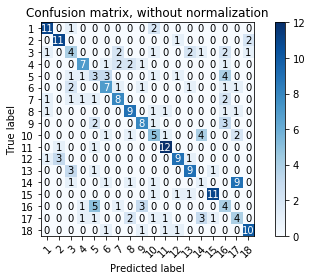

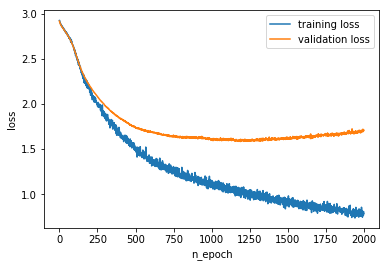

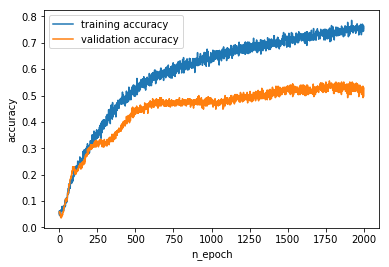

The final Validation Accuracy: 52.78%
Execution time:  22727.105855464935


In [14]:
# Train with 20,000 updates with compensating for the unbalanced dataset
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 20
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 20
sig2 = np.sqrt(2./(n1*k2))
# weights
K = YTr.shape[0]
fsize = n2*(nlen-k1-k2+2)
sig3 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=2000,shuf=True,
          verbose=True,show_plot=True,imbalance=True,momentum=True,save_name='bias')
toc = time.time()
print('Execution time: ',toc-tic)

# Train with more convolutional layer

In [ ]:
# Search for good number of layer and good number of filter of each layer
import pickle

nlen = int(XTr.shape[0]/d_char)

conv_layers = [2,3,4]
k_f = [5,3,3]
num_filters = [5,10,15,20]

K = YTr.shape[0]
model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

result = {}
ind_search = 0
for k_layer in conv_layers:
    net_struc = {}
    n_in = d_char
    for n_f in num_filters:
        fsize = nlen
        for i in range(k_layer):
            fsize = fsize-k_f[i]+1
            if i==0:
                sig = np.sqrt(2./(10*k_f[0]))
            else:
                sig = np.sqrt(2./(n_in*k_f[i]))
            net_struc[i] = {'std':sig, 'filter':[n_in,k_f[i],n_f]}
            n_in = n_f
        fsize = fsize*n_f                            
        net_struc[k_layer] = {'std':np.sqrt(2./fsize), 'weight':[K,fsize]} 

        net = ConvNetwork(**model_paras)
        tic = time.time()
        net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=20,shuf=True,
                  imbalance=True,momentum=True)
        toc = time.time()
        print('Execution time: ',toc-tic)
        loss,acc,y_pred = net.test(XVa,YVa,yVa)
        
        result[ind_search] = dict(net_struc=net_struc, val_acc=acc, val_loss=loss, n_epochs=20)
        
with open('search_'+name_par+'.txt', 'wb') as fp:
    pickle.dump(result, fp)

# Train more conv layers with bias terms

Epoch: 99 - Training Accuracy: 17.14% Loss: 2.6247480527604448 Validation Accuracy: 15.87%
Epoch: 199 - Training Accuracy: 30.98% Loss: 2.187916127443791 Validation Accuracy: 26.98%
Epoch: 299 - Training Accuracy: 40.3% Loss: 1.848623322190596 Validation Accuracy: 36.51%
Epoch: 399 - Training Accuracy: 47.46% Loss: 1.6522371244717924 Validation Accuracy: 42.06%
Epoch: 499 - Training Accuracy: 50.94% Loss: 1.5335761884286105 Validation Accuracy: 44.05%
Epoch: 599 - Training Accuracy: 55.84% Loss: 1.407091547259254 Validation Accuracy: 42.46%
Epoch: 699 - Training Accuracy: 59.51% Loss: 1.2958954461124874 Validation Accuracy: 45.24%
Epoch: 799 - Training Accuracy: 61.68% Loss: 1.184121303379616 Validation Accuracy: 44.84%
Epoch: 899 - Training Accuracy: 62.24% Loss: 1.21015465989299 Validation Accuracy: 44.05%
Epoch: 999 - Training Accuracy: 65.54% Loss: 1.0918135811975758 Validation Accuracy: 46.83%
Epoch: 1099 - Training Accuracy: 65.44% Loss: 1.0674479221249022 Validation Accuracy: 47

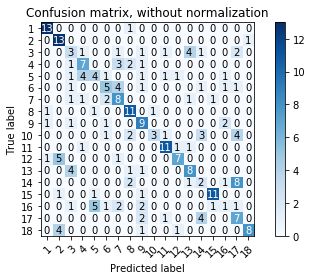

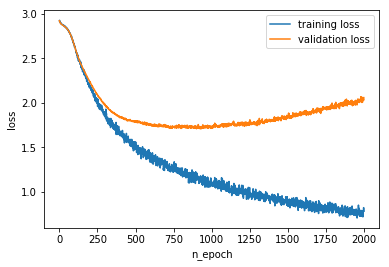

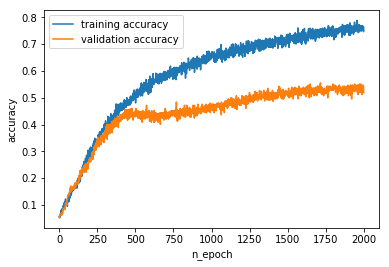

The final Validation Accuracy: 51.98%
Execution time:  7776.548129081726


In [15]:
# Train with 20,000 updates with compensating for the unbalanced dataset
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 15
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 15
sig2 = np.sqrt(2./(n1*k2))
# filter layer 3
k3 = 3
n3 = 15
sig3 = np.sqrt(2./(n2*k3))
# weights
K = YTr.shape[0]
fsize = n3*(nlen-k1-k2-k3+3)
sig4 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'filter':[n2,k3,n3]},  # filter 3
             3:{'std':sig4, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=2000,shuf=True,
          verbose=True,show_plot=True,imbalance=True,momentum=True,save_name='bias_best')
toc = time.time()
print('Execution time: ',toc-tic)

In [24]:
_,P,y_pred = net.forward(XTr)

In [28]:
print(net.computeAccuracy(yTr,y_pred))

0.6776947166380443


Epoch: 99 - Training Accuracy: 16.76% Loss: 2.7110760039370425 Validation Accuracy: 12.7%
Epoch: 199 - Training Accuracy: 22.13% Loss: 2.3931486545906093 Validation Accuracy: 17.06%
Epoch: 299 - Training Accuracy: 29.57% Loss: 2.1326251494846797 Validation Accuracy: 26.19%
Epoch: 399 - Training Accuracy: 35.59% Loss: 1.9166505713959126 Validation Accuracy: 30.95%
Epoch: 499 - Training Accuracy: 38.98% Loss: 1.8007200584246814 Validation Accuracy: 34.92%
Epoch: 599 - Training Accuracy: 45.57% Loss: 1.62106355913575 Validation Accuracy: 37.3%
Epoch: 699 - Training Accuracy: 46.52% Loss: 1.5499139548719723 Validation Accuracy: 38.1%
Epoch: 799 - Training Accuracy: 50.75% Loss: 1.4863516451477234 Validation Accuracy: 41.67%
Epoch: 899 - Training Accuracy: 55.56% Loss: 1.3326545584341893 Validation Accuracy: 42.06%
Epoch: 999 - Training Accuracy: 54.71% Loss: 1.3467408728996253 Validation Accuracy: 42.46%
Epoch: 1099 - Training Accuracy: 55.56% Loss: 1.2526142184406286 Validation Accuracy: 

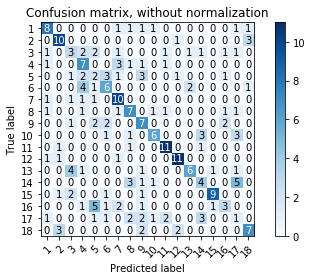

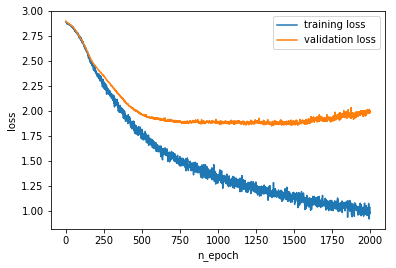

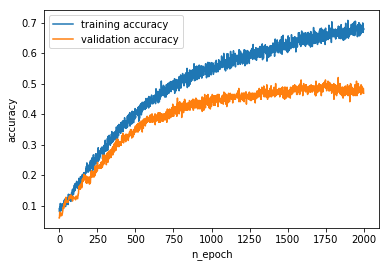

The final Validation Accuracy: 46.83%
Execution time:  7338.493629455566


In [43]:
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 10
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 10
sig2 = np.sqrt(2./(n1*k2))
# filter layer 3
k3 = 3
n3 = 10
sig3 = np.sqrt(2./(n2*k3))
# weights
K = YTr.shape[0]
fsize = n3*(nlen-k1-k2-k3+3)
sig4 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'filter':[n2,k3,n3]},  # filter 3
             3:{'std':sig4, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=2000,shuf=True,
          verbose=True,show_plot=True,imbalance=True,momentum=True,save_name='bias_best')
toc = time.time()
print('Execution time: ',toc-tic)

Epoch: 99 - Training Accuracy: 13.94% Loss: 2.7141779799503087 Validation Accuracy: 14.29%
Epoch: 199 - Training Accuracy: 22.6% Loss: 2.39557597815456 Validation Accuracy: 20.63%
Epoch: 299 - Training Accuracy: 30.23% Loss: 2.1098620508311203 Validation Accuracy: 25.4%
Epoch: 399 - Training Accuracy: 35.88% Loss: 1.8727169489210977 Validation Accuracy: 31.75%
Epoch: 499 - Training Accuracy: 44.26% Loss: 1.6060843254695822 Validation Accuracy: 35.71%
Epoch: 599 - Training Accuracy: 49.53% Loss: 1.467147294644093 Validation Accuracy: 40.87%
Epoch: 699 - Training Accuracy: 54.14% Loss: 1.3812865421115523 Validation Accuracy: 44.84%
Epoch: 799 - Training Accuracy: 55.27% Loss: 1.3236534048742916 Validation Accuracy: 45.63%
Epoch: 899 - Training Accuracy: 60.17% Loss: 1.1789081353812998 Validation Accuracy: 48.02%
Epoch: 999 - Training Accuracy: 65.63% Loss: 1.0788863069349164 Validation Accuracy: 47.22%
Epoch: 1099 - Training Accuracy: 67.04% Loss: 1.0224710407870308 Validation Accuracy: 

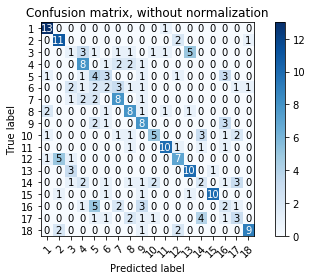

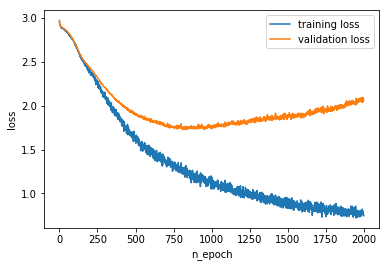

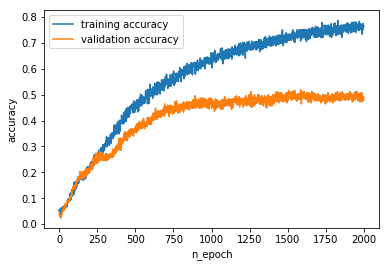

The final Validation Accuracy: 48.02%
Execution time:  29357.16341304779


In [44]:
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 20
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 10
sig2 = np.sqrt(2./(n1*k2))
# filter layer 3
k3 = 3
n3 = 10
sig3 = np.sqrt(2./(n2*k3))
# weights
K = YTr.shape[0]
fsize = n3*(nlen-k1-k2-k3+3)
sig4 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'filter':[n2,k3,n3]},  # filter 3
             3:{'std':sig4, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=2000,shuf=True,
          verbose=True,show_plot=True,imbalance=True,momentum=True,save_name='bias_best')
toc = time.time()
print('Execution time: ',toc-tic)

Epoch: 49 - Training Accuracy: 9.7% Loss: 2.8063462996950976 Validation Accuracy: 10.32%
Epoch: 99 - Training Accuracy: 12.71% Loss: 2.7025108339837303 Validation Accuracy: 13.1%
Epoch: 149 - Training Accuracy: 19.4% Loss: 2.5579218762587272 Validation Accuracy: 17.46%
Epoch: 199 - Training Accuracy: 21.47% Loss: 2.388003663230336 Validation Accuracy: 19.05%
Epoch: 249 - Training Accuracy: 27.97% Loss: 2.2755880493380465 Validation Accuracy: 25.0%
Epoch: 299 - Training Accuracy: 29.1% Loss: 2.1483090646853564 Validation Accuracy: 29.76%
Epoch: 349 - Training Accuracy: 34.46% Loss: 1.9934663945752464 Validation Accuracy: 28.17%
Epoch: 399 - Training Accuracy: 38.14% Loss: 1.896142935178346 Validation Accuracy: 30.56%
Epoch: 449 - Training Accuracy: 38.14% Loss: 1.8368787620493916 Validation Accuracy: 32.14%
Epoch: 499 - Training Accuracy: 44.44% Loss: 1.686370072752466 Validation Accuracy: 35.32%
Epoch: 549 - Training Accuracy: 46.05% Loss: 1.6541521723915007 Validation Accuracy: 35.32%

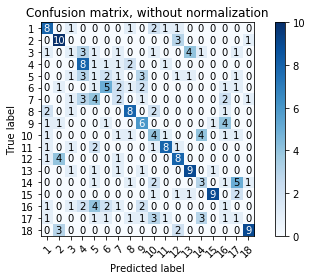

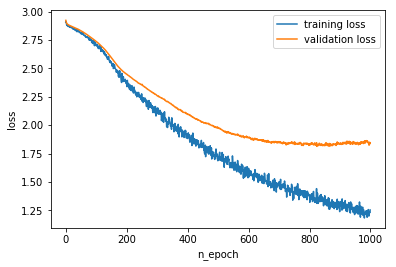

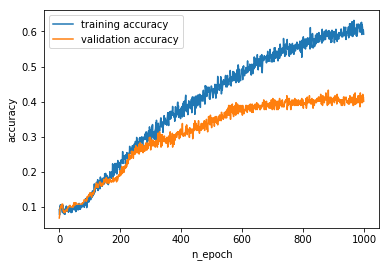

The final Validation Accuracy: 40.08%
Execution time:  13842.0286962986


In [11]:
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 20
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 10
sig2 = np.sqrt(2./(n1*k2))
# filter layer 3
k3 = 3
n3 = 5
sig3 = np.sqrt(2./(n2*k3))
# weights
K = YTr.shape[0]
fsize = n3*(nlen-k1-k2-k3+3)
sig4 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'filter':[n2,k3,n3]},  # filter 3
             3:{'std':sig4, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=2000,shuf=True,
          verbose=True,show_plot=True,imbalance=True,momentum=True,save_name='bias_best_20')
toc = time.time()
print('Execution time: ',toc-tic)

In [ ]:
nlen = int(XTr.shape[0]/d_char)
# filter layer 1
k1 = 5
n1 = 20
sig1 = np.sqrt(2./(10*k1))  # For the first layer where input is sparse d_char is set is 10
# filter layer 2
k2 = 3
n2 = 20
sig2 = np.sqrt(2./(n1*k2))
# filter layer 3
k3 = 3
n3 = 10
sig3 = np.sqrt(2./(n2*k3))
# weights
K = YTr.shape[0]
fsize = n3*(nlen-k1-k2-k3+3)
sig4 = np.sqrt(2./fsize)

model_paras = {"eta": 0.001,  # learning rate
               "n_batch": 59,  # size of data batches within an epoch
               "rho": 0.9,  # momentum term
              }

net_struc = {0:{'std':sig1,'filter':[d_char,k1,n1]}, # filter 1
             1:{'std':sig2,'filter':[n1,k2,n2]},  # filter 2
             2:{'std':sig3,'filter':[n2,k3,n3]},  # filter 3
             3:{'std':sig4, 'weight':[K,fsize]}  # weights
            } 

net = ConvNetwork(**model_paras)
tic = time.time()
net.train(net_struc,[XTr,XVa],[YTr,YVa],[yTr,yVa],d_char,n_epochs=3000,shuf=True,
          imbalance=True,momentum=True,save_name='bias_best_20_3000')
toc = time.time()
print('Execution time: ',toc-tic)